# Preprocesamiento del Dataset y Selección de Variables

Este notebook tienen como objetivo la fase de "ingeniería" donde transformamos los **datos crudos** (los que obtuvimos en el EDA) en el combustible limpio y de alto octanaje que usaremos para entrenar nuestros modelos.

Basado en nuestros hallazgos en la fase anterior (outliers, gaps, MNAR, correlaciones), tomarmos decicisones que nos lleven a alcanzar ese objetivo.

# Fase A: Preparación de Datos Base

## 1. Carga de Datos

In [15]:
# Seteo inicial

import sys
import logging
import warnings
from pathlib import Path

# Configuración de logging y advertencias
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
warnings.filterwarnings('ignore')


# Configuración de Paths
BASE_DIR = Path('../').resolve()
DATA_DIR = BASE_DIR / 'data'
SRC_DIR = BASE_DIR / 'src'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
sys.path.append(str(SRC_DIR))

logging.info(f"Directorio Base: {BASE_DIR}")
logging.info(f"Directorio de Datos: {DATA_DIR}")
logging.info(f"Directorio Procesado: {PROCESSED_DIR}")
logging.info(f"Directorio Src: {SRC_DIR}")

2025-11-14 19:05:32,170 - Directorio Base: C:\Users\vex_a\Documents\IA\3ro\2doCuatri\LabDatos\Practica\lab-datos-TPF
2025-11-14 19:05:32,175 - Directorio de Datos: C:\Users\vex_a\Documents\IA\3ro\2doCuatri\LabDatos\Practica\lab-datos-TPF\data
2025-11-14 19:05:32,177 - Directorio Procesado: C:\Users\vex_a\Documents\IA\3ro\2doCuatri\LabDatos\Practica\lab-datos-TPF\data\processed
2025-11-14 19:05:32,177 - Directorio Src: C:\Users\vex_a\Documents\IA\3ro\2doCuatri\LabDatos\Practica\lab-datos-TPF\src


### Cargar el Dataset Base

In [16]:
import pandas as pd

df = pd.read_csv(PROCESSED_DIR / 'dataset_v01.csv', parse_dates=['Fecha'], index_col='Fecha')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1190 entries, 2020-07-01 23:59:00 to 2023-10-26 07:00:00
Columns: 149 entries, Planta (Kw) to Totalizador_Filtracion
dtypes: float64(145), int64(4)
memory usage: 1.4 MB


---

## 2. Limpieza y Acondicionamiento de fechas.

### Limpieza de Rango de Fechas

Como vimos durante el EDA, algunas de nuestras fechas faltan o estan incompletas (no llegan hasta las 23:59). En este apartado vamos a tratar esas filas para dejarlas en condiciones antes del preporcesado.

In [17]:
# Ejemplo de fila incompleta
df.last_valid_index()

Timestamp('2023-10-26 07:00:00')

En este caso, como `2023-10-26` es la última fila lo más sencillo es eliminarla. Esto ya que no provoca una pérdida de continuidad y tenemos datos suficientes como para permitirnoslo.

In [18]:
df = df.loc[df.index < '2023-10-26']

# Nuestra fecha máxima de datos ahora es 2023-10-25
df.last_valid_index()

Timestamp('2023-10-25 23:59:00')

Ahora vamos a buscar las fechas con horas distintas a las `23:59:00` y decidiremos si las eliminamos (considerándolas como día faltantes) o si las conservamos como están.

In [19]:
import numpy as np

# Verificar si hay fechas con horas distintas a 23:59:00

# Extraer la hora de cada índice
df_horas = df.index.to_series().apply(lambda x: x.strftime('%H:%M:%S'))

# Identificar las fechas que no terminan en 23:59:00
fechas_incompletas = df[df_horas != '23:59:00']

print(f"Total de fechas con horas distintas a 23:59:00: {len(fechas_incompletas)}")

print("\nFechas incompletas encontradas:")
# Las ordenamos por hora de forma ascendente para facilitar su revisión y solo comparamos la columna 'Frio (Kw)'
fechas_incompletas = fechas_incompletas.assign(hora=df_horas[df_horas != '23:59:00']).sort_values(by='hora')
display(fechas_incompletas['Frio (Kw)'])

Total de fechas con horas distintas a 23:59:00: 19

Fechas incompletas encontradas:


Fecha
2023-04-19 16:00:00    13439.0
2023-04-13 19:00:00    14315.0
2022-03-02 23:00:00    19294.0
2021-07-13 23:00:00    33704.0
2023-02-23 23:59:01    20688.0
2022-12-08 23:59:01    21663.0
2022-04-29 23:59:01    31316.0
2022-04-05 23:59:01    22573.0
2020-08-12 23:59:01    29964.0
2021-04-11 23:59:01    26888.0
2020-12-30 23:59:01    11433.0
2020-10-22 23:59:01    28374.0
2020-10-08 23:59:01    30220.0
2020-08-25 23:59:01    37809.0
2021-08-25 23:59:01    37122.0
2023-07-07 23:59:01    22348.0
2023-06-30 23:59:59    20274.0
2021-06-30 23:59:59    32571.0
2022-06-30 23:59:59    26459.0
Name: Frio (Kw), dtype: float64

Como vemos, la gran mayoría de estas fechas tienen diferencias de **segundos** con la hora que estamos comparando, por lo que vamos a tomarlas como válidas. También lo haremos con las fechas con hora `23:00:00`, siguen aportando información relevante y suficiente para nuestro análisis.

En cambio, aquellos días que poseen horas `< 23:00:00` vamos a eliminarlas y las tomaremos como valores faltantes que trataremos más adelante.

In [20]:
print("Shape previo a filtrado:", df.shape)

df =  df.loc[~((df.index.to_series().apply(lambda x: x.strftime('%H:%M:%S')) < '23:00:00'))]

print("Shape posterior a filtrado:", df.shape)

Shape previo a filtrado: (1189, 149)
Shape posterior a filtrado: (1187, 149)


In [21]:
# Eliminar la hora del índice, dejando solo la fecha
df.index = df.index.normalize()
df.tail()

,Planta (Kw),Elaboracion (Kw),Bodega (Kw),Cocina (Kw),Envasado (Kw),Linea 2 (Kw),Linea 3 (Kw),Linea 4 (Kw),Servicios (Kw),Sala Maq (Kw),...,Tot L3. L4 y Planta de CO2,Tot A40/240/50/60/Centec/Filtro,Tot A130/330/430,"Tot L3, L4 y Planta de CO2",Totalizador_L2_Barriles,Totalizador_L3,Totaliador_Latas,Totalizador_Bodega,Totalizador_Tq_Pulmon,Totalizador_Filtracion
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-10-21,21627.800000,2383.0,3119.0,242.0,452.0,461.300000,546.0,0.0,16977.0,9793.0,...,NaN,2194.000,6922.250,40.12500,0.0,0.0,0.0,0.0000,1649.0,0.0
2023-10-22,30287.570000,3200.0,2788.0,1387.0,2758.0,4351.070000,584.0,0.0,20821.0,11873.0,...,NaN,2070.875,6019.625,72.56250,1271.0,0.0,0.0,7.9375,2863.0,1.0
2023-10-23,28667.480000,2329.0,2882.0,313.0,3339.0,5503.480000,550.0,0.0,18771.0,10395.0,...,NaN,1828.250,6030.000,74.53125,1323.0,0.0,0.0,0.0000,3244.0,1.0
2023-10-24,31263.160156,3077.0,3405.0,235.0,5513.0,6940.660156,1287.0,0.0,18461.0,10614.0,...,NaN,728.500,6006.000,79.78125,1485.0,0.0,0.0,952.0625,4538.0,737.0
2023-10-25,30501.320312,3194.0,3671.0,251.0,4306.0,6812.820312,528.0,0.0,18692.0,10809.0,...,NaN,1191.625,5969.625,54.93750,1217.0,0.0,0.0,1690.5625,4756.0,1552.0


### Tratado de Gaps y re-index de fechas

En el EDA encontramos que nuestro dataset presentaba inconsistencias en cuanto a la continuidad temporal, nos faltaban algunos días de manera aleatoria y otros no tanto. Vamos a analizar los contextos y solucionar respecto a ellos:

**Análisis de las Opciones**

- **Días 31 Faltantes:**

    - *Opción 1:* Asumir meses de 30 días. 
    En esta opción estaríamos eliminando días reales de consumo (como 31/Ene, 31/Mar, 31/Jul) solo porque algunos 31s fallaron. Esto sesgaría la estacionalidad y perderíamos información valiosa.

    - *Opción 2:* Imputar. 
    Estos parecen ser errores de registro (aleatorios o sistemáticos). La planta operó y consumió energía, pero el dato no se guardó. Deben ser tratados como NaN y ser imputados más tarde.

- **Agosto 29, 30, 31 (Patrón Anual):**
    
    La mejor estrategia sería asumir que estos días la planta tiene consumo cero. Esto probablemente se deba a un *cierre de mantenimiento programado anual* al final del verano.
    
    Imputaremos 0 en esos días para enseñarle a los modelos dos cosas vitales:

    1. Que el consumo en esos días específicos es cero (o cercano a cero).
    
    2. Cómo es el arranque de la planta el 1 de septiembre (el lag_1_Frio será 0, algo que el modelo debe aprender).

In [22]:
# --- Reindexar para exponer los Gaps ---

# Usamos tu rango de fechas corregido

print(f"Forma original: {df.shape}")
# Definir el rango de fechas completo y correcto
full_date_range = pd.date_range(start='2020-07-01', end='2023-10-25', freq='D')

# Re-indexar para crear los 42 días faltantes como filas NaN
df_full = df.reindex(full_date_range)
print(f"Forma re-indexada: {df_full.shape}")

Forma original: (1187, 149)
Forma re-indexada: (1212, 149)


In [23]:
# --- Imputar manualmente todo con 0 ---

# Usamos .loc[] para asignar el valor en las filas correctas
shutdown_mask = ((df_full.index.month == 8) & 
                 ((df_full.index.day == 29) | (df_full.index.day == 30) | (df_full.index.day == 31))
                )
df_full.loc[shutdown_mask, :] = 0

# Validación
print("Validación de imputación manual (debería ser 0.0):")
print(df_full.loc['2020-08-29']['Frio (Kw)'])
print(df_full.loc['2021-08-30']['Frio (Kw)'])
print(df_full.loc['2022-08-31']['Frio (Kw)'])

Validación de imputación manual (debería ser 0.0):
0.0
0.0
0.0


### Eliminación de columnas sin información

In [24]:
df_full.isna().sum().sort_values(ascending=False).loc[lambda x: x > 0]

Agua Envasado (Hl)         1200
Agua Paste L3              1200
Agua Lavadora L3           1200
Agua Cond Evaporativos     1200
Agua Calderas              1200
                           ... 
Vapor L3                     14
Totalizador_Aire_Bodega      14
Tot Aire Expulsion           14
Aire Servicios (M3)          14
Totalizador_Aire_L5          14
Length: 149, dtype: int64

Columnas eliminadas por tener más del 30% de valores NaN: 36
Forma del dataset después de eliminar columnas sin información: (1212, 113)


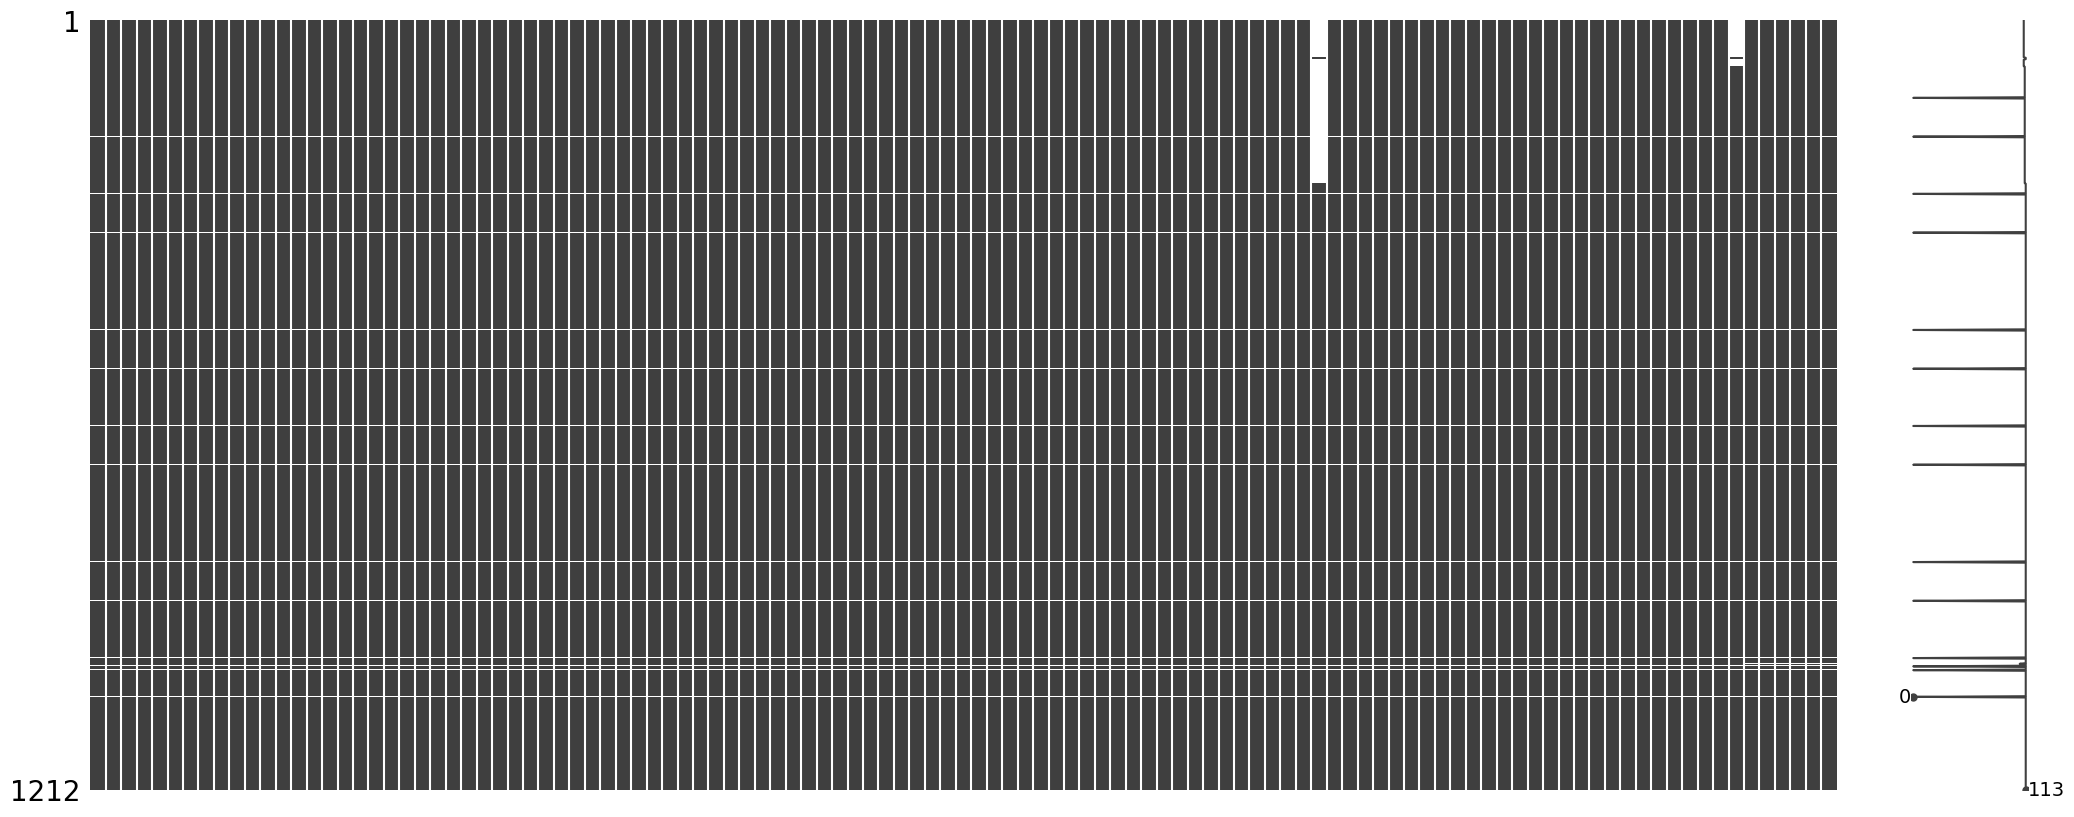

In [25]:
# --- Eliminar columnas sin información ---

# Eliminar columnas con más del 30% de valores NaN
df_full = df_full.loc[:, df_full.isna().mean() < 0.3]

# Tamaño del dataset después de eliminar columnas sin información
print("Columnas eliminadas por tener más del 30% de valores NaN:", df.shape[1] - df_full.shape[1])
print(f"Forma del dataset después de eliminar columnas sin información: {df_full.shape}")
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df_full)
plt.show()

In [26]:
from aux_functions import track_data_artifact

df_full.to_csv(PROCESSED_DIR / 'dataset_v2.csv')

track_data_artifact(
	PROCESSED_DIR / 'dataset_v2.csv',
	'Dataset con fechas normalizadas y gaps expuestos',
	[PROCESSED_DIR / 'dataset_v2.csv'],
	parameters={'description': 'Dataset con fechas normalizadas, gaps expuestos y mantenimientos de agosto imputados a 0'},
	base_dir=BASE_DIR,
	checksums_file_path=DATA_DIR / 'checksums.json',
	lineage_file_path=PROCESSED_DIR / 'data_lineage.json',
)

2025-11-14 19:05:33,421 - --- Iniciando tracking de artefacto para: dataset_v2.csv ---
2025-11-14 19:05:33,451 - Checksum (SHA256): 314bab45d0b09b5183451a3b0757b33efc3c9d09945ae47339cccc96082d6644
2025-11-14 19:05:33,457 - Checksum guardado en checksums.json
2025-11-14 19:05:33,462 - Data lineage actualizado en data_lineage.json
2025-11-14 19:05:33,463 - --- Tracking de artefacto completado ---


---

## 3. Split de Datos

In [27]:
# Dividir en train, val y test para busqueda de hiperparámetros del pipeline de preprocesamiento

# Train 70%
train_size = int(len(df_full) * 0.7)
train_df = df_full.iloc[:train_size]

# Validation 10%
val_size = int(len(df_full) * 0.1)
val_df = df_full.iloc[train_size:train_size + val_size]

# Test 20%
test_df = df_full.iloc[train_size + val_size:]

print("Train:")
print(f"- shape: {train_df.shape}")
print(f"- Rango: {train_df.index.min()} to {train_df.index.max()}")

print("\nValidation:")
print(f"- shape: {val_df.shape}")
print(f"- Rango: {val_df.index.min()} to {val_df.index.max()}")

print("\nTest:")
print(f"- shape: {test_df.shape}")
print(f"- Rango: {test_df.index.min()} to {test_df.index.max()}")

Train:
- shape: (848, 113)
- Rango: 2020-07-01 00:00:00 to 2022-10-26 00:00:00

Validation:
- shape: (121, 113)
- Rango: 2022-10-27 00:00:00 to 2023-02-24 00:00:00

Test:
- shape: (243, 113)
- Rango: 2023-02-25 00:00:00 to 2023-10-25 00:00:00


In [28]:
# Guardar el dataset de test en csv para uso posterior
test_df.to_csv(PROCESSED_DIR / 'dataset_test_v2.csv')